In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

## Notebook Setup

magic cell that declares `\bm{}` latex macro.
$\newcommand{\bm}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

### Imports

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()

plt.style.use('seaborn-paper')

In [3]:
import re
import itertools
from pathlib import Path
import json
from typing import List

import pandas as pd
from pandas import IndexSlice as idx
import numpy as np
from bert_score import BERTScorer
from sklearn.metrics import classification_report, f1_score
from tqdm.auto import tqdm

from guidedsum.mimic.preprocess import label_texts
from guidedsum import evaluation
from guidedsum.evaluation import load_summaries
from guidedsum.mimic.base import is_abstractive

### Evaluation Utility

In [4]:
NL_BERT_SCORER = BERTScorer(
    model_type="bert-base-multilingual-uncased",
    num_layers=9,
    lang="nl",
    rescale_with_baseline=True,
)

EN_BERT_SCORER = BERTScorer(
    model_type="bert-base-uncased",
    num_layers=9,
    lang="en",
    rescale_with_baseline=True,
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predic

In [5]:
def evaluate_runs(docs, runs, bert_scorer, chexpert_f1=False, chexpert_ground_truth=None, chexpert_chunksize=500):
    for run_path, step, _ in tqdm(runs): 
        run_path = Path(run_path)
        metrics_file = run_path / f'best.metrics.json'
        score_file = run_path / f'best.scores.csv'
        chexpert_labels_file = run_path / 'best.chexpert-labels.json'
        chexpert_metrics_file = run_path / 'best.chexpert-metrics.json'
        
        evaluate_base = not metrics_file.exists()
        evaluate_chexpert = not chexpert_metrics_file.exists() and chexpert_f1        
        if not evaluate_base and not evaluate_chexpert:
            print(f'done: {run_path}')
            continue
        
        print(f'evaluate: {run_path}')
        try:    
            df_run = evaluation.load_summaries(run_path, step=step)
        except FileNotFoundError as e:
            print(f'WARNING: {e}')
            continue
            
        # ROUGE, BERTScore, Compression, Novelty, ...
        if evaluate_base:
            metrics = evaluation.evaluate_run(
                docs,
                df_run['candidate'],
                df_run['gold'],
                bert_scorer
            )
            metrics.to_csv(score_file)
            metrics.mean().to_json(metrics_file)
            
        # Factual F1 (CheXpert)
        if evaluate_chexpert:
            cands = df_run['candidate']
            # CheXpert cannot handle empty texts, so we replace them with "-".
            # Also replace sentence boundary markers with newlines
            cands = cands.replace('', '-').str.replace('<q>', '\n')
            candidate_labels = label_texts(cands, chunksize=chexpert_chunksize)
            
            # Persist labels for later analysis
            with open(chexpert_labels_file, 'w') as fout:
                json.dump(candidate_labels, fout)
                fout.write('\n')
                
            # Calculate and persist factual f1
            factual_f1 = evaluation.calculate_factual_f1(candidate_labels, chexpert_ground_truth)
            factual_f1.to_json(chexpert_metrics_file)

## Evaluate

In [6]:
def best_step(run_path):
    run_path = Path(run_path)
    try:
        with open(run_path / 'model_step_best.txt') as fin:
            return int(fin.read().strip())
    except FileNotFoundError:
        return -1

### MIMIC-Official

In [7]:
# Lookup the best step in validate.log of BertExt, BertAbs and GSum (OracleExt)
STEP_BERTEXT = best_step('../output/mimic-official-unguided/bertext-default/')
STEP_BERTABS = best_step('../output/mimic-official-unguided/bertabs-default/')
STEP_GSUM = best_step('../output/mimic-official-oracle/gsum-default/')
STEP_WGSUM = best_step("../output/mimic-official-wgsum/wgsum-default/")
STEP_WGSUM_CL = best_step("../output/mimic-official-wgsum-cl/wgsum-cl-default/")

MIMIC_OFFICIAL_RUNS = [
    # run_path, step, result_key
    ('../output/mimic-official-unguided/oracle/', 0, "eo"),
    ('../output/mimic-official-unguided/bertext-default/', STEP_BERTEXT, "bertext"),
    
    # BertExt with variable-length output
    ('../output/mimic-official-unguided/bertext-default-clip-k1/', STEP_BERTEXT, "bertext_k1"),
    ('../output/mimic-official-unguided/bertext-default-clip-k2/', STEP_BERTEXT, "bertext_k2"),
    ('../output/mimic-official-unguided/bertext-default-clip-k3/', STEP_BERTEXT, "bertext_k3"),
    ('../output/mimic-official-unguided/bertext-default-clip-k4/', STEP_BERTEXT, "bertext_k4"),
    ('../output/mimic-official-unguided/bertext-default-clip-k5/', STEP_BERTEXT, "bertext_k5"),
    ('../output/mimic-official-unguided/bertext-default-clip-oracle/', STEP_BERTEXT, "bertext_oracleclip"),
    ('../output/mimic-official-unguided/bertext-default-clip-lrapprox/', STEP_BERTEXT, "bertext_lrapproxclip"),
    ('../output/mimic-official-unguided/bertext-default-clip-bertapprox/', STEP_BERTEXT, "bertext_bertapproxclip"),
    ('../output/mimic-official-unguided/bertext-default-clip-threshold/', STEP_BERTEXT, "bertext_threshold"),
    
    ("../output/mimic-official-unguided/bertabs-default/", STEP_BERTABS, "bertabs"),
    
    ("../output/mimic-official-wgsum/wgsum-default/", STEP_WGSUM, "wgsum"),
    ("../output/mimic-official-wgsum-cl/wgsum-cl-default/", STEP_WGSUM_CL, "wgsum+cl"),

    
    # GSum w/ BertExt
    ("../output/mimic-official-bertext-default-clip-k1/gsum-default/", STEP_GSUM, "ext_sents_autok1"),
    ("../output/mimic-official-bertext-default-clip-k2/gsum-default/", STEP_GSUM, "ext_sents_autok2"),
    ("../output/mimic-official-bertext-default-clip-k3/gsum-default/", STEP_GSUM, "ext_sents_autok3"),
    ("../output/mimic-official-bertext-default-clip-k4/gsum-default/", STEP_GSUM, "ext_sents_autok4"),
    ("../output/mimic-official-bertext-default-clip-k5/gsum-default/", STEP_GSUM, "ext_sents_autok5"),
    
    # GSum w/ BertExt (adaptive length)
    ("../output/mimic-official-bertext-default-clip-oracle/gsum-default/", STEP_GSUM, "ext_sents_auto_oracleclip"), 
    ("../output/mimic-official-bertext-default-clip-lrapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_lrapproxclip"),
    ("../output/mimic-official-bertext-default-clip-bertapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_bertapproxclip"),
    ("../output/mimic-official-bertext-default-clip-threshold/gsum-default/", STEP_GSUM, "ext_sents_auto_thresholdclip"),
   
    # Gsum w/ OracleExt
    ("../output/mimic-official-oracle/gsum-default/", STEP_GSUM, "ext_sents_oracle"),
]

df = pd.read_json("../data/processed/mimic-official-unguided/reports.test.json")
docs = df['src'].apply(lambda sents: '<q>'.join((' '.join(sent) for sent in sents)))
chexpert_ground_truth = pd.read_json('../data/processed/mimic-official/reports.test.json')['chexpert_labels_impression'].tolist()
evaluate_runs(
    docs,
    MIMIC_OFFICIAL_RUNS,
    EN_BERT_SCORER,
    chexpert_f1=True,
    chexpert_ground_truth=chexpert_ground_truth,
    chexpert_chunksize=100
)

  0%|          | 0/24 [00:00<?, ?it/s]

done: ../output/mimic-official-unguided/oracle
done: ../output/mimic-official-unguided/bertext-default
done: ../output/mimic-official-unguided/bertext-default-clip-k1
done: ../output/mimic-official-unguided/bertext-default-clip-k2
done: ../output/mimic-official-unguided/bertext-default-clip-k3
done: ../output/mimic-official-unguided/bertext-default-clip-k4
done: ../output/mimic-official-unguided/bertext-default-clip-k5
done: ../output/mimic-official-unguided/bertext-default-clip-oracle
done: ../output/mimic-official-unguided/bertext-default-clip-lrapprox
done: ../output/mimic-official-unguided/bertext-default-clip-bertapprox
done: ../output/mimic-official-unguided/bertext-default-clip-threshold
done: ../output/mimic-official-unguided/bertabs-default
done: ../output/mimic-official-wgsum/wgsum-default
done: ../output/mimic-official-wgsum-cl/wgsum-cl-default
done: ../output/mimic-official-bertext-default-clip-k1/gsum-default
done: ../output/mimic-official-bertext-default-clip-k2/gsum-defa

### MIMIC-Official-BG

In [8]:
# Lookup the best step in validate.log of BertExt, BertAbs and GSum (OracleExt)
STEP_BERTEXT = best_step('../output/mimic-official-bg-unguided/bertext-default/')
STEP_BERTABS = best_step('../output/mimic-official-bg-unguided/bertabs-default/')
STEP_GSUM = best_step('../output/mimic-official-bg-oracle/gsum-default/')
STEP_WGSUM = best_step("../output/mimic-official-bg-wgsum/wgsum-default/")
STEP_WGSUM_CL = best_step("../output/mimic-official-bg-wgsum-cl/wgsum-cl-default/")


MIMIC_OFFICIAL_BG_RUNS = [
    # run_path, step, result_key
    ('../output/mimic-official-bg-unguided/oracle/', 0, "eo"),
    ('../output/mimic-official-bg-unguided/bertext-default/', STEP_BERTEXT, "bertext"),
    
    # BertExt with variable-length output
    ('../output/mimic-official-bg-unguided/bertext-default-clip-k1/', STEP_BERTEXT, "bertext_k1"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-k2/', STEP_BERTEXT, "bertext_k2"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-k3/', STEP_BERTEXT, "bertext_k3"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-k4/', STEP_BERTEXT, "bertext_k4"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-k5/', STEP_BERTEXT, "bertext_k5"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-oracle/', STEP_BERTEXT, "bertext_oracleclip"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-lrapprox/', STEP_BERTEXT, "bertext_lrapproxclip"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-bertapprox/', STEP_BERTEXT, "bertext_bertapproxclip"),
    ('../output/mimic-official-bg-unguided/bertext-default-clip-threshold/', STEP_BERTEXT, "bertext_threshold"),
    
    ("../output/mimic-official-bg-unguided/bertabs-default/", STEP_BERTABS, "bertabs"),
    
    ("../output/mimic-official-bg-wgsum/wgsum-default/", STEP_WGSUM, "wgsum"),
    ("../output/mimic-official-bg-wgsum-cl/wgsum-cl-default/", STEP_WGSUM_CL, "wgsum+cl"),
    
    # GSum w/ BertExt
    ("../output/mimic-official-bg-bertext-default-clip-k1/gsum-default/", STEP_GSUM, "ext_sents_autok1"),
    ("../output/mimic-official-bg-bertext-default-clip-k2/gsum-default/", STEP_GSUM, "ext_sents_autok2"),
    ("../output/mimic-official-bg-bertext-default-clip-k3/gsum-default/", STEP_GSUM, "ext_sents_autok3"),
    ("../output/mimic-official-bg-bertext-default-clip-k4/gsum-default/", STEP_GSUM, "ext_sents_autok4"),
    ("../output/mimic-official-bg-bertext-default-clip-k5/gsum-default/", STEP_GSUM, "ext_sents_autok5"),
    
    # GSum w/ BertExt (adaptive length)
    ("../output/mimic-official-bg-bertext-default-clip-oracle/gsum-default/", STEP_GSUM, "ext_sents_auto_oracleclip"), 
    ("../output/mimic-official-bg-bertext-default-clip-lrapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_lrapproxclip"),
    ("../output/mimic-official-bg-bertext-default-clip-bertapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_bertapproxclip"),
    ("../output/mimic-official-bg-bertext-default-clip-threshold/gsum-default/", STEP_GSUM, "ext_sents_auto_thresholdclip"),
   
    # Gsum w/ OracleExt
    ("../output/mimic-official-bg-oracle/gsum-default/", STEP_GSUM, "ext_sents_oracle"),
]

df = pd.read_json("../data/processed/mimic-official-bg-unguided/reports.test.json")
docs = df['src'].apply(lambda sents: '<q>'.join((' '.join(sent) for sent in sents)))
chexpert_ground_truth = pd.read_json('../data/processed/mimic-official/reports.test.json')['chexpert_labels_impression'].tolist()
evaluate_runs(
    docs,
    MIMIC_OFFICIAL_BG_RUNS,
    EN_BERT_SCORER,
    chexpert_f1=True,
    chexpert_ground_truth=chexpert_ground_truth,
    chexpert_chunksize=100
)

  0%|          | 0/24 [00:00<?, ?it/s]

done: ../output/mimic-official-bg-unguided/oracle
done: ../output/mimic-official-bg-unguided/bertext-default
done: ../output/mimic-official-bg-unguided/bertext-default-clip-k1
done: ../output/mimic-official-bg-unguided/bertext-default-clip-k2
done: ../output/mimic-official-bg-unguided/bertext-default-clip-k3
done: ../output/mimic-official-bg-unguided/bertext-default-clip-k4
done: ../output/mimic-official-bg-unguided/bertext-default-clip-k5
done: ../output/mimic-official-bg-unguided/bertext-default-clip-oracle
done: ../output/mimic-official-bg-unguided/bertext-default-clip-lrapprox
done: ../output/mimic-official-bg-unguided/bertext-default-clip-bertapprox
done: ../output/mimic-official-bg-unguided/bertext-default-clip-threshold
done: ../output/mimic-official-bg-unguided/bertabs-default
done: ../output/mimic-official-bg-wgsum/wgsum-default
done: ../output/mimic-official-bg-wgsum-cl/wgsum-cl-default
done: ../output/mimic-official-bg-bertext-default-clip-k1/gsum-default
done: ../output/mim

### OpenI

In [9]:
# Lookup the best step in validate.log of BertExt, BertAbs and GSum (OracleExt)
STEP_BERTEXT = best_step('../output/openi-unguided/bertext-default')
STEP_BERTABS = best_step('../output/openi-unguided/bertabs-default')
STEP_GSUM = best_step("../output/openi-oracle/gsum-default/")
STEP_WGSUM = best_step("../output/openi-wgsum/wgsum-default/")
STEP_WGSUM_CL = best_step("../output/openi-wgsum-cl/wgsum-cl-default/")

OPENI_RUNS = [
    # run_path, step, result_key
    ('../output/openi-unguided/oracle/', 0, "eo"),
    ('../output/openi-unguided/bertext-default/', STEP_BERTEXT, "bertext"),
    
    # BertExt with variable-length output
    ('../output/openi-unguided/bertext-default-clip-k1/', STEP_BERTEXT, "bertext_k1"),
    ('../output/openi-unguided/bertext-default-clip-k2/', STEP_BERTEXT, "bertext_k2"),
    ('../output/openi-unguided/bertext-default-clip-k3/', STEP_BERTEXT, "bertext_k3"),
    ('../output/openi-unguided/bertext-default-clip-k4/', STEP_BERTEXT, "bertext_k4"),
    ('../output/openi-unguided/bertext-default-clip-k5/', STEP_BERTEXT, "bertext_k5"),
    ('../output/openi-unguided/bertext-default-clip-oracle/', STEP_BERTEXT, "bertext_oracleclip"),
    ('../output/openi-unguided/bertext-default-clip-lrapprox/', STEP_BERTEXT, "bertext_lrapproxclip"),
    ('../output/openi-unguided/bertext-default-clip-bertapprox/', STEP_BERTEXT, "bertext_bertapproxclip"),
    ('../output/openi-unguided/bertext-default-clip-threshold/', STEP_BERTEXT, "bertext_threshold"),
    
    ("../output/openi-unguided/bertabs-default/", STEP_BERTABS, "bertabs"),
    
    # WGSum / WGSum+CL
    ("../output/openi-wgsum/wgsum-default/", STEP_WGSUM, "wgsum"),
    ("../output/openi-wgsum-cl/wgsum-cl-default/", STEP_WGSUM_CL, "wgsum+cl"),
       
    # GSum w/ BertExt
    ("../output/openi-bertext-default-clip-k1/gsum-default/", STEP_GSUM, "ext_sents_autok1"),
    ("../output/openi-bertext-default-clip-k2/gsum-default/", STEP_GSUM, "ext_sents_autok2"),
    ("../output/openi-bertext-default-clip-k3/gsum-default/", STEP_GSUM, "ext_sents_autok3"),
    ("../output/openi-bertext-default-clip-k4/gsum-default/", STEP_GSUM, "ext_sents_autok4"),
    ("../output/openi-bertext-default-clip-k5/gsum-default/", STEP_GSUM, "ext_sents_autok5"),
    
    # GSum w/ BertExt (adaptive length)
    ("../output/openi-bertext-default-clip-oracle/gsum-default/", STEP_GSUM, "ext_sents_auto_oracleclip"), 
    ("../output/openi-bertext-default-clip-lrapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_lrapproxclip"),
    ("../output/openi-bertext-default-clip-bertapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_bertapproxclip"),
    ("../output/openi-bertext-default-clip-threshold/gsum-default/", STEP_GSUM, "ext_sents_auto_thresholdclip"),

    # Gsum w/ OracleExt
    ("../output/openi-oracle/gsum-default/", STEP_GSUM, "ext_sents_oracle"),   
]

df = pd.read_json("../data/processed/openi-unguided/reports.test.json")
docs = df['src'].apply(lambda sents: '<q>'.join((' '.join(sent) for sent in sents)))
chexpert_ground_truth = pd.read_json('../data/processed/openi/reports.test.json')['chexpert_labels_impression'].tolist()
evaluate_runs(
    docs,
    OPENI_RUNS,
    EN_BERT_SCORER,
    chexpert_f1=True,
    chexpert_ground_truth=chexpert_ground_truth,
    chexpert_chunksize=100
)

  0%|          | 0/24 [00:00<?, ?it/s]

done: ../output/openi-unguided/oracle
done: ../output/openi-unguided/bertext-default
done: ../output/openi-unguided/bertext-default-clip-k1
done: ../output/openi-unguided/bertext-default-clip-k2
done: ../output/openi-unguided/bertext-default-clip-k3
done: ../output/openi-unguided/bertext-default-clip-k4
done: ../output/openi-unguided/bertext-default-clip-k5
done: ../output/openi-unguided/bertext-default-clip-oracle
done: ../output/openi-unguided/bertext-default-clip-lrapprox
done: ../output/openi-unguided/bertext-default-clip-bertapprox
done: ../output/openi-unguided/bertext-default-clip-threshold
done: ../output/openi-unguided/bertabs-default
done: ../output/openi-wgsum/wgsum-default
done: ../output/openi-wgsum-cl/wgsum-cl-default
done: ../output/openi-bertext-default-clip-k1/gsum-default
done: ../output/openi-bertext-default-clip-k2/gsum-default
done: ../output/openi-bertext-default-clip-k3/gsum-default
done: ../output/openi-bertext-default-clip-k4/gsum-default
done: ../output/openi-

### OpenI-BG

In [10]:
# Lookup the best step in validate.log of BertExt, BertAbs and GSum (OracleExt)
STEP_BERTEXT = best_step('../output/openi-bg-unguided/bertext-default')
STEP_BERTABS = best_step('../output/openi-bg-unguided/bertabs-default')
STEP_GSUM = best_step("../output/openi-bg-oracle/gsum-default/")
STEP_WGSUM = best_step("../output/openi-bg-wgsum/wgsum-default/")
STEP_WGSUM_CL = best_step("../output/openi-bg-wgsum-cl/wgsum-cl-default/")

OPENI_BG_RUNS = [
    # run_path, step, result_key
    ('../output/openi-bg-unguided/oracle/', 0, "eo"),
    ('../output/openi-bg-unguided/bertext-default/', STEP_BERTEXT, "bertext"),
    
    # BertExt with variable-length output
    ('../output/openi-bg-unguided/bertext-default-clip-k1/', STEP_BERTEXT, "bertext_k1"),
    ('../output/openi-bg-unguided/bertext-default-clip-k2/', STEP_BERTEXT, "bertext_k2"),
    ('../output/openi-bg-unguided/bertext-default-clip-k3/', STEP_BERTEXT, "bertext_k3"),
    ('../output/openi-bg-unguided/bertext-default-clip-k4/', STEP_BERTEXT, "bertext_k4"),
    ('../output/openi-bg-unguided/bertext-default-clip-k5/', STEP_BERTEXT, "bertext_k5"),
    ('../output/openi-bg-unguided/bertext-default-clip-oracle/', STEP_BERTEXT, "bertext_oracleclip"),
    ('../output/openi-bg-unguided/bertext-default-clip-lrapprox/', STEP_BERTEXT, "bertext_lrapproxclip"),
    ('../output/openi-bg-unguided/bertext-default-clip-bertapprox/', STEP_BERTEXT, "bertext_bertapproxclip"),
    ('../output/openi-bg-unguided/bertext-default-clip-threshold/', STEP_BERTEXT, "bertext_threshold"),
    
    ("../output/openi-bg-unguided/bertabs-default/", STEP_BERTABS, "bertabs"),
    
    # WGSum / WGSum+CL
    ("../output/openi-bg-wgsum/wgsum-default/", STEP_WGSUM, "wgsum"),
    ("../output/openi-bg-wgsum-cl/wgsum-cl-default/", STEP_WGSUM_CL, "wgsum+cl"),
       
    # GSum w/ BertExt
    ("../output/openi-bg-bertext-default-clip-k1/gsum-default/", STEP_GSUM, "ext_sents_autok1"),
    ("../output/openi-bg-bertext-default-clip-k2/gsum-default/", STEP_GSUM, "ext_sents_autok2"),
    ("../output/openi-bg-bertext-default-clip-k3/gsum-default/", STEP_GSUM, "ext_sents_autok3"),
    ("../output/openi-bg-bertext-default-clip-k4/gsum-default/", STEP_GSUM, "ext_sents_autok4"),
    ("../output/openi-bg-bertext-default-clip-k5/gsum-default/", STEP_GSUM, "ext_sents_autok5"),
    
    # GSum w/ BertExt (adaptive length)
    ("../output/openi-bg-bertext-default-clip-oracle/gsum-default/", STEP_GSUM, "ext_sents_auto_oracleclip"), 
    ("../output/openi-bg-bertext-default-clip-lrapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_lrapproxclip"),
    ("../output/openi-bg-bertext-default-clip-bertapprox/gsum-default/", STEP_GSUM, "ext_sents_auto_bertapproxclip"),
    ("../output/openi-bg-bertext-default-clip-threshold/gsum-default/", STEP_GSUM, "ext_sents_auto_thresholdclip"),

    # Gsum w/ OracleExt
    ("../output/openi-bg-oracle/gsum-default/", STEP_GSUM, "ext_sents_oracle"),   
]

df = pd.read_json("../data/processed/openi-bg-unguided/reports.test.json")
docs = df['src'].apply(lambda sents: '<q>'.join((' '.join(sent) for sent in sents)))
chexpert_ground_truth = pd.read_json('../data/processed/openi/reports.test.json')['chexpert_labels_impression'].tolist()
evaluate_runs(
    docs,
    OPENI_BG_RUNS,
    EN_BERT_SCORER,
    chexpert_f1=True,
    chexpert_ground_truth=chexpert_ground_truth,
    chexpert_chunksize=100
)

  0%|          | 0/24 [00:00<?, ?it/s]

done: ../output/openi-bg-unguided/oracle
done: ../output/openi-bg-unguided/bertext-default
done: ../output/openi-bg-unguided/bertext-default-clip-k1
done: ../output/openi-bg-unguided/bertext-default-clip-k2
done: ../output/openi-bg-unguided/bertext-default-clip-k3
done: ../output/openi-bg-unguided/bertext-default-clip-k4
done: ../output/openi-bg-unguided/bertext-default-clip-k5
done: ../output/openi-bg-unguided/bertext-default-clip-oracle
done: ../output/openi-bg-unguided/bertext-default-clip-lrapprox
done: ../output/openi-bg-unguided/bertext-default-clip-bertapprox
done: ../output/openi-bg-unguided/bertext-default-clip-threshold
done: ../output/openi-bg-unguided/bertabs-default
done: ../output/openi-bg-wgsum/wgsum-default
done: ../output/openi-bg-wgsum-cl/wgsum-cl-default
done: ../output/openi-bg-bertext-default-clip-k1/gsum-default
done: ../output/openi-bg-bertext-default-clip-k2/gsum-default
done: ../output/openi-bg-bertext-default-clip-k3/gsum-default
done: ../output/openi-bg-berte

## Load Evaluation Results

In [11]:
#### MIMIC official splits ####

# WGSum / WGSum+CL results are clipped to one decimal

# WGSum (Hu et al. 2021), Table 3 - MIMIC (official) - WGSUM (TRANS+GAT)
# https://aclanthology.org/2021.findings-acl.441
wgsum_official = pd.Series(
    name='wgsum*',
    index=['rouge1', 'rouge2', 'rougeLsum'],
    data=[0.483, 0.333, 0.466]
)

# WGSum+CL (Hu et al. 2022) - Table 3 - MIMIC (official split) "OURS"
# https://aclanthology.org/2022.acl-long.320
wgsumcl_official = pd.Series(
    name='wgsum+cl*',
    index=['rouge1', 'rouge2', 'rougeLsum'],
    data=[0.491, 0.337, 0.471]
)

df_mimic_official_baselines = pd.concat([wgsum_official, wgsumcl_official], axis=1).T


#### OpenI ####
# WGSum (Hu et al. 2021), Table 3 - OpenI - WGSUM (TRANS+GAT)
# https://aclanthology.org/2021.findings-acl.441
wgsum_openi = pd.Series(
    name='wgsum*',
    index=['rouge1', 'rouge2', 'rougeLsum'],
    data=[0.616, 0.509, 0.617]
)
# WGSum+CL (Hu et al. 2022) - Table 3 - OpenI "OURS"
# https://aclanthology.org/2022.acl-long.320
wgsumcl_openi = pd.Series(
    name='wgsum+cl*',
    index=['rouge1', 'rouge2', 'rougeLsum'],
    data=[0.649, 0.555, 0.644]
)
df_openi_baselines = pd.concat([wgsum_openi, wgsumcl_openi], axis=1).T


df_baselines = pd.concat([df_mimic_official_baselines, df_openi_baselines], axis=1, keys=['mimic-official', 'openi'])
df_baselines

mimic-official                   openi                 
                  rouge1 rouge2 rougeLsum rouge1 rouge2 rougeLsum
wgsum*             0.483  0.333     0.466  0.616  0.509     0.617
wgsum+cl*          0.491  0.337     0.471  0.649  0.555     0.644

In [12]:
metrics = []
all_datasets = [
    (MIMIC_OFFICIAL_RUNS, 'mimic-official'),
    (MIMIC_OFFICIAL_BG_RUNS, 'mimic-official-bg'),
    (OPENI_RUNS, 'openi'),
    (OPENI_BG_RUNS, 'openi-bg'),
]

for runs, dataset in all_datasets:
    for run_path, step, result_key in runs:
        try:
            s = pd.read_json(f'{run_path}/best.metrics.json', typ="series")
        except ValueError:
            s = pd.Series(dtype='object')
        s['run_path'] = run_path
        s['result_key'] = result_key
        s['step'] = step
        s['dataset'] = dataset
        metrics.append(s)

df_metrics = pd.DataFrame(metrics)
# pivot by dataset https://stackoverflow.com/q/50861081
df_metrics = df_metrics \
    .pivot(index='result_key', columns='dataset') \
    .swaplevel(0, 1, axis=1) \
    .sort_index(axis=1)
df_metrics = df_metrics.append(df_baselines)


def load_chexpert_scores(runs):
    all_runs = []
    for run_path, step, run_key in runs:
        try:
            scores = pd.read_json(Path(run_path) / 'best.chexpert-metrics.json', typ='series')
        except ValueError: 
            print('missing chexpert metrics for', run_path)
            continue
            
        scores.name = run_key
        all_runs.append(scores)
    df = pd.concat(all_runs, axis=1) 
    return df

df_metrics.loc[:, ('mimic-official', 'factual_f1')] = load_chexpert_scores(MIMIC_OFFICIAL_RUNS).mean()
df_metrics.loc[:, ('mimic-official-bg', 'factual_f1')] = load_chexpert_scores(MIMIC_OFFICIAL_BG_RUNS).mean()
df_metrics.loc[:, ('openi', 'factual_f1')] = load_chexpert_scores(OPENI_RUNS).mean()
df_metrics.loc[:, ('openi-bg', 'factual_f1')] = load_chexpert_scores(OPENI_BG_RUNS).mean()

df_metrics

mimic-official                      \
                                bertscore_f1 bertscore_precision   
bertabs                             0.587774            0.637898   
bertext                             0.418865            0.451740   
bertext_bertapproxclip              0.437785            0.430780   
bertext_k1                          0.418865            0.451740   
bertext_k2                          0.448155            0.409294   
bertext_k3                          0.441501            0.369560   
bertext_k4                          0.428656            0.339953   
bertext_k5                          0.418888            0.321855   
bertext_lrapproxclip                0.434067            0.437199   
bertext_oracleclip                  0.452548            0.441603   
bertext_threshold                   0.451601            0.430352   
eo                                  0.501185            0.493102   
ext_sents_auto_bertapproxclip       0.594865            0.637402   
ext_sents_auto_lrapproxclip         0.590692            0.637875   
ext_sents_auto_oracleclip           0.611747            0.649927   
ext_sents_auto_thresholdclip        0.598488            0.626407   
ext_sents_autok1                    0.574363            0.645943   
ext_sents_autok2                    0.574864            0.581499   
ext_sents_autok3                    0.557894            0.535655   
ext_sents_autok4                    0.542699            0.504379   
ext_sents_autok5                    0.530908            0.483324   
ext_sents_oracle                    0.660414            0.702280   
wgsum                               0.586229            0.618407   
wgsum+cl                            0.594740            0.644061   
wgsum*                                   NaN                 NaN   
wgsum+cl*                                NaN                 NaN   

                                                                    \
                              bertscore_recall     cmp_s     cmp_w   
bertabs                               0.556922  0.742206  0.812564   
bertext                               0.400781  0.821633  0.761857   
bertext_bertapproxclip                0.455209  0.747885  0.683700   
bertext_k1                            0.400781  0.821633  0.761857   
bertext_k2                            0.501044  0.644518  0.572892   
bertext_k3                            0.535448  0.469958  0.403915   
bertext_k4                            0.545928  0.315966  0.268342   
bertext_k5                            0.548696  0.201836  0.173328   
bertext_lrapproxclip                  0.442608  0.764197  0.699081   
bertext_oracleclip                    0.472449  0.728663  0.666707   
bertext_threshold                     0.485867  0.703926  0.633644   
eo                                    0.520257  0.729793  0.678334   
ext_sents_auto_bertapproxclip         0.570151  0.736694  0.793177   
ext_sents_auto_lrapproxclip           0.562540  0.742038  0.799187   
ext_sents_auto_oracleclip             0.588708  0.723664  0.786041   
ext_sents_auto_thresholdclip          0.587768  0.709865  0.770692   
ext_sents_autok1                      0.527874  0.775671  0.829024   
ext_sents_autok2                      0.585323  0.669258  0.745506   
ext_sents_autok3                      0.598902  0.598287  0.690444   
ext_sents_autok4                      0.601600  0.548880  0.650577   
ext_sents_autok5                      0.600617  0.521573  0.626079   
ext_sents_oracle                      0.633047  0.727251  0.790582   
wgsum                                 0.572088  0.709674  0.781788   
wgsum+cl                              0.564235  0.750900  0.805661   
wgsum*                                     NaN       NaN       NaN   
wgsum+cl*                                  NaN       NaN       NaN   

                                                                        \
                              length_delta n_sents_doc n_sents_summary   
bertabs         

## Prepare LaTeX Tables

### Main results

In [13]:
metrics = {
    'rouge1': 'R-1',
    'rouge2': 'R-2',
    'rougeLsum': 'R-L',
    'bertscore_f1': 'BS',
    'factual_f1': 'Fact.',
}

results = {   
    # Baselines: extractive, abstractive and standard GSum
    'eo': 'OracleExt',
    'bertext': 'BertExt',
    'bertabs': 'BertAbs',
    'ext_sents_autok1': 'GSum (Dou et al., 2021)',
       
    # GSum adapted with a variable-length guidance signal (ours)
    'ext_sents_auto_lrapproxclip': 'GSum w/ LR-Approx',
    'ext_sents_auto_bertapproxclip': 'GSum w/ BERT-Approx',
    'ext_sents_auto_thresholdclip': 'GSum w/ Thresholding',

    # Domain-specific methods
    'wgsum': 'WGSum',
    'wgsum+cl': 'WGSum+CL',
    
    'wgsum*': 'WGSum*',
    'wgsum+cl*': 'WGSum+CL*',
}


ignore_max = ['eo', 'ext_sents_auto_oracleclip', 'ext_sents_oracle']
runs_max = [value for key, value in results.items() if key not in ignore_max] # map to display name

datasets = {
    'mimic-official': 'MIMIC-CXR',
    'openi': 'OpenI',
}

df = df_metrics.copy()
df = df[datasets.keys()]
df = df.loc[results.keys()] # Change order of results
df = df.reindex(metrics.keys(), axis=1, level=1) # Change order of metrics
df = df.rename(metrics, axis=1, level=1) # Rename metrics for display
df = df.rename(results) # Rename results for display
df = df.rename(datasets, axis=1, level=0) # Rename datasets
df = df.rename_axis([None, 'Method'], axis=1).rename_axis(None, axis=0)
df = (df * 100).round(1)
display(df)

tmp = df.loc[runs_max]
for col, row in tmp.idxmax().iteritems():
    df.loc[row, col] = '\textbf{' + str(df.loc[row, col]) + '}'

tex = df.to_latex(
    na_rep="---",
    position='t',
    escape=False,
    index_names=True,
    column_format='l' + 'r' * len(df.columns), # Align: left for row label, right for all numbers
    multicolumn_format='c',
)
tex = tex.replace('table', 'table*')
tex = tex.replace('\\centering', '\\small\n\centering')
# tex = tex.replace('\centering', '\centering\n\\resizebox{\\textwidth}{!}{')
# tex = tex.replace('\end{tabular}', '\end{tabular}}')
tex = tex.replace('Method', '\\textbf{Method}')

for dataset_name in datasets.values():
    tex = tex.replace(dataset_name, '\\textbf{' + dataset_name + '}')
    
tex = re.sub(r' +', ' ', tex)
print(tex)

MIMIC-CXR                         OpenI              \
Method                        R-1   R-2   R-L    BS Fact.   R-1   R-2   R-L   
OracleExt                    44.0  25.4  40.6  50.1  55.1  30.5  11.9  29.2   
BertExt                      32.7  18.1  30.0  41.9  44.5  23.6   7.4  22.6   
BertAbs                      48.4  34.1  46.6  58.8  47.3  62.0  52.7  61.7   
GSum (Dou et al., 2021)      46.3  32.7  44.7  57.4  46.6  60.1  49.6  59.8   
GSum w/ LR-Approx            48.9  34.2  47.0  59.1  48.2  62.0  51.2  61.6   
GSum w/ BERT-Approx          49.4  34.5  47.4  59.5  50.6  62.5  51.6  62.2   
GSum w/ Thresholding         49.9  34.3  47.8  59.8  49.0  62.2  50.8  61.8   
WGSum                        48.4  32.8  46.5  58.6  49.8  61.1  50.0  60.8   
WGSum+CL                     49.5  35.3  47.8  59.5  51.1  64.7  57.1  64.5   
WGSum*                       48.3  33.3  46.6   NaN   NaN  61.6  50.9  61.7   
WGSum+CL*                    49.1  33.7  47.1   NaN   NaN  64.9  55.5  64.4   

                                     
Method                     BS Fact.  
OracleExt                33.7  53.5  
BertExt                  32.2  42.8  
BertAbs                  69.2  39.3  
GSum (Dou et al., 2021)  67.0  40.0  
GSum w/ LR-Approx        67.9  41.7  
GSum w/ BERT-Approx      68.4  39.6  
GSum w/ Thresholding     68.6  40.4  
WGSum                    67.9  38.4  
WGSum+CL                 70.0  37.2  
WGSum*                    NaN   NaN  
WGSum+CL*                 NaN   NaN

\begin{table*}[t]
\small
\centering
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{c}{\textbf{MIMIC-CXR}} & \multicolumn{5}{c}{\textbf{OpenI}} \\
\textbf{Method} & R-1 & R-2 & R-L & BS & Fact. & R-1 & R-2 & R-L & BS & Fact. \\
\midrule
OracleExt & 44.0 & 25.4 & 40.6 & 50.1 & 55.1 & 30.5 & 11.9 & 29.2 & 33.7 & 53.5 \\
BertExt & 32.7 & 18.1 & 30.0 & 41.9 & 44.5 & 23.6 & 7.4 & 22.6 & 32.2 & \textbf{42.8} \\
BertAbs & 48.4 & 34.1 & 46.6 & 58.8 & 47.3 & 62.0 & 52.7 & 61.7 & 69.2 & 39.3 \\
GSum (Dou et al., 2021) & 46.3 & 32.7 & 44.7 & 57.4 & 46.6 & 60.1 & 49.6 & 59.8 & 67.0 & 40.0 \\
GSum w/ LR-Approx & 48.9 & 34.2 & 47.0 & 59.1 & 48.2 & 62.0 & 51.2 & 61.6 & 67.9 & 41.7 \\
GSum w/ BERT-Approx & 49.4 & 34.5 & 47.4 & 59.5 & 50.6 & 62.5 & 51.6 & 62.2 & 68.4 & 39.6 \\
GSum w/ Thresholding & \textbf{49.9} & 34.3 & \textbf{47.8} & \textbf{59.8} & 49.0 & 62.2 & 50.8 & 61.8 & 68.6 & 40.4 \\
WGSum & 48.4 & 32.8 & 46.5 & 58.6 & 49.8 & 61.1 & 50.0 & 60.8 & 67.9 & 38.4 \\
WGSum+CL & 49.5 & 

### Main results with background

In [14]:
metrics = {
    'rouge1': 'R-1',
    'rouge2': 'R-2',
    'rougeLsum': 'R-L',
    'bertscore_f1': 'BS',
    'factual_f1': 'Fact.',
}

results = {    
    # Baselines: extractive, abstractive and standard GSum
    'eo': 'OracleExt',
    'bertext': 'BertExt',
    'bertabs': 'BertAbs',
    'ext_sents_autok1': 'GSum (Dou et al., 2021)',
       
    # GSum adapted with a variable-length guidance signal (ours)
    'ext_sents_auto_lrapproxclip': 'GSum w/ LR-Approx',
    'ext_sents_auto_bertapproxclip': 'GSum w/ BERT-Approx',
    'ext_sents_auto_thresholdclip': 'GSum w/ Thresholding',
        
    # Domain-specific methods
    'wgsum': 'WGSum',
    'wgsum+cl': 'WGSum+CL',
}


ignore_max = ['eo', 'ext_sents_auto_oracleclip', 'ext_sents_oracle']
runs_max = [value for key, value in results.items() if key not in ignore_max] # map to display name

datasets = {
    'mimic-official-bg': 'MIMIC-CXR (BG)',
    'openi-bg': 'OpenI (BG)',
}

df = df_metrics.copy()
df = df[datasets.keys()]
df = df.loc[results.keys()] # Change order of results
df = df.reindex(metrics.keys(), axis=1, level=1) # Change order of metrics
df = df.rename(metrics, axis=1, level=1) # Rename metrics for display
df = df.rename(results) # Rename results for display
df = df.rename(datasets, axis=1, level=0) # Rename datasets
df = df.rename_axis([None, 'Method'], axis=1).rename_axis(None, axis=0)
df = (df * 100).round(1)
display(df)

tmp = df.loc[runs_max]
for col, row in tmp.idxmax().iteritems():
    df.loc[row, col] = '\textbf{' + str(df.loc[row, col]) + '}'

tex = df.to_latex(
    na_rep="-",
    position='t',
    escape=False,
    index_names=True,
    column_format='l' + 'r' * len(df.columns), # Align: left for row label, right for all numbers
    multicolumn_format='c',
)
tex = tex.replace('table', 'table*')
tex = tex.replace('\\centering', '\\small\n\centering')
# tex = tex.replace('\centering', '\centering\n\\resizebox{\\textwidth}{!}{')
# tex = tex.replace('\end{tabular}', '\end{tabular}}')
tex = tex.replace('Method', '\\textbf{Method}')

for dataset_name in datasets.values():
    tex = tex.replace(dataset_name, '\\textbf{' + dataset_name + '}')
    
tex = re.sub(r' +', ' ', tex)
print(tex)

MIMIC-CXR (BG)                         OpenI (BG)  \
Method                             R-1   R-2   R-L    BS Fact.        R-1   
OracleExt                         44.3  25.3  40.8  50.4  55.7       30.6   
BertExt                           32.9  18.2  30.2  42.1  44.7       23.1   
BertAbs                           49.8  35.3  48.1  60.1  51.8       66.4   
GSum (Dou et al., 2021)           48.3  34.3  46.4  59.3  49.9       62.8   
GSum w/ LR-Approx                 50.5  35.6  48.4  60.6  50.2       63.2   
GSum w/ BERT-Approx               51.0  35.8  48.8  60.8  50.7       63.6   
GSum w/ Thresholding              51.5  36.0  49.3  61.4  52.0       64.2   
WGSum                             50.6  34.9  48.5  60.5  52.9       58.6   
WGSum+CL                          51.6  37.2  49.8  61.5  50.1       65.2   

                                                 
Method                    R-2   R-L    BS Fact.  
OracleExt                11.5  29.1  34.0  51.7  
BertExt                   6.8  22.0  31.1  39.0  
BertAbs                  58.2  66.0  71.4  41.2  
GSum (Dou et al., 2021)  53.2  62.5  69.4  40.4  
GSum w/ LR-Approx        52.7  62.9  70.0  40.0  
GSum w/ BERT-Approx      52.9  63.3  70.2  39.9  
GSum w/ Thresholding     53.8  63.9  70.7  41.4  
WGSum                    47.0  58.4  66.6  36.8  
WGSum+CL                 56.6  64.9  71.1  43.1

\begin{table*}[t]
\small
\centering
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{c}{\textbf{MIMIC-CXR (BG)}} & \multicolumn{5}{c}{\textbf{OpenI (BG)}} \\
\textbf{Method} & R-1 & R-2 & R-L & BS & Fact. & R-1 & R-2 & R-L & BS & Fact. \\
\midrule
OracleExt & 44.3 & 25.3 & 40.8 & 50.4 & 55.7 & 30.6 & 11.5 & 29.1 & 34.0 & 51.7 \\
BertExt & 32.9 & 18.2 & 30.2 & 42.1 & 44.7 & 23.1 & 6.8 & 22.0 & 31.1 & 39.0 \\
BertAbs & 49.8 & 35.3 & 48.1 & 60.1 & 51.8 & \textbf{66.4} & \textbf{58.2} & \textbf{66.0} & \textbf{71.4} & 41.2 \\
GSum (Dou et al., 2021) & 48.3 & 34.3 & 46.4 & 59.3 & 49.9 & 62.8 & 53.2 & 62.5 & 69.4 & 40.4 \\
GSum w/ LR-Approx & 50.5 & 35.6 & 48.4 & 60.6 & 50.2 & 63.2 & 52.7 & 62.9 & 70.0 & 40.0 \\
GSum w/ BERT-Approx & 51.0 & 35.8 & 48.8 & 60.8 & 50.7 & 63.6 & 52.9 & 63.3 & 70.2 & 39.9 \\
GSum w/ Thresholding & 51.5 & 36.0 & 49.3 & 61.4 & 52.0 & 64.2 & 53.8 & 63.9 & 70.7 & 41.4 \\
WGSum & 50.6 & 34.9 & 48.5 & 60.5 & \textbf{52.9} & 58.6 & 47.0 & 58.4 & 66.6 & 36.8 \\

### Background vs. No Background Visualization

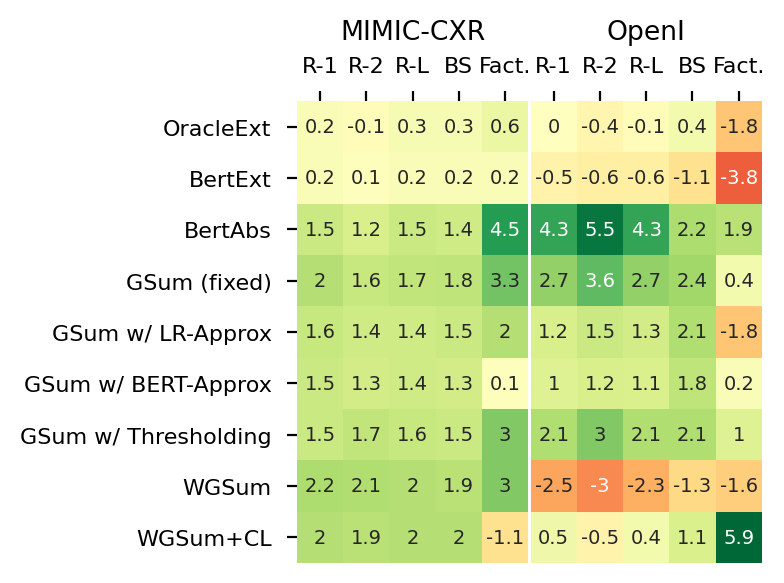

In [15]:
metrics = {
    'rouge1': 'R-1',
    'rouge2': 'R-2',
    'rougeLsum': 'R-L',
    'bertscore_f1': 'BS',
    'factual_f1': 'Fact.',
}

results = {
    ### Part 1: reproduction of GSum and baselines
    
    # Baselines: extractive, abstractive and standard GSum
    'eo': 'OracleExt',
    'bertext': 'BertExt',
    'bertabs': 'BertAbs',
    'ext_sents_autok1': 'GSum (fixed)',
       
    # GSum adapted with a variable-length guidance signal (ours)
    'ext_sents_auto_lrapproxclip': 'GSum w/ LR-Approx',
    'ext_sents_auto_bertapproxclip': 'GSum w/ BERT-Approx',
    'ext_sents_auto_thresholdclip': 'GSum w/ Thresholding',

   
    ### Part 2: comparsion with domain-specific methods
    
    # Domain-specific methods
    'wgsum': 'WGSum',
    'wgsum+cl': 'WGSum+CL',
}

datasets = {
    'mimic-official': 'MIMIC-CXR',
    'openi': 'OpenI',
}

df = df_metrics.copy()
df = df[datasets.keys()]
df = df.loc[results.keys()] # Change order of results
df = df.reindex(metrics.keys(), axis=1, level=1) # Change order of metrics
df = df.rename(metrics, axis=1, level=1) # Rename metrics for display
df = df.rename(results) # Rename results for display
df = df.rename(datasets, axis=1, level=0) # Rename datasets
df = df.rename_axis([None, 'Method'], axis=1).rename_axis(None, axis=0)
df_without_bg = df.copy()


datasets = {
    'mimic-official-bg': 'MIMIC-CXR',
    'openi-bg': 'OpenI',
}

df = df_metrics.copy()
df = df[datasets.keys()]
df = df.loc[results.keys()] # Change order of results
df = df.reindex(metrics.keys(), axis=1, level=1) # Change order of metrics
df = df.rename(metrics, axis=1, level=1) # Rename metrics for display
df = df.rename(results) # Rename results for display
df = df.rename(datasets, axis=1, level=0) # Rename datasets
df = df.rename_axis([None, 'Method'], axis=1).rename_axis(None, axis=0)
df_with_bg = df.copy()

### Draw the plot
plt.style.use('seaborn-paper')

diff = df_with_bg.dropna() - df_without_bg.dropna()
diff = (diff * 100).round(1)

fig, axs = plt.subplots(1,2, sharey=True,  gridspec_kw = {'wspace':0.01, 'hspace':0}, figsize=(3,3))

vmin = diff.min().min()
vmax = diff.max().max()

sns.heatmap(diff['MIMIC-CXR'], cmap='RdYlGn', annot=True, linecolor='black', cbar=False, center=0, ax=axs[0], vmin=vmin, vmax=vmax, annot_kws={"size": 7})
sns.heatmap(diff['OpenI'], cmap='RdYlGn', annot=True, linecolor='black', cbar=False, center=0, ax=axs[1], vmin=vmin, vmax=vmax, annot_kws={"size": 7})
axs[0].set_xlabel('');
axs[1].set_xlabel('');
axs[0].tick_params(axis='x', which='major', labelbottom = False, bottom=False, top = True, labeltop=True)
axs[1].tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = True, labeltop=True, left=False)
axs[0].set_title('MIMIC-CXR')
axs[1].set_title('OpenI')

with PdfPages('../paper/figures/mimic-openi-background-delta.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

### GSum with Oracle Guidance

In [16]:
metrics = {
    'rouge1': 'R-1',
    'rouge2': 'R-2',
    'rougeLsum': 'R-L',
    'bertscore_f1': 'BS',
    'factual_f1': 'Fact.',
}

results = {   
    'bertabs': 'BertAbs',
    'ext_sents_autok1': 'Fixed (k=1)',
    'ext_sents_auto_oracleclip': 'Oracle Length',
    'ext_sents_oracle': 'Oracle Length + Content',
}

datasets = {
    'mimic-official': 'MIMIC-CXR',
    'openi': 'OpenI',
}

df = df_metrics.copy()
df = df[datasets.keys()]
df = df.loc[results.keys()] # Change order of results
df = df.reindex(metrics.keys(), axis=1, level=1) # Change order of metrics
df = df.rename(metrics, axis=1, level=1) # Rename metrics for display
df = df.rename(results) # Rename results for display
df = df.rename(datasets, axis=1, level=0) # Rename datasets
df = df.rename_axis([None, 'Method'], axis=1).rename_axis(None, axis=0)
df = (df * 100).round(1)
print('MIMIC-CXR')
display(df['MIMIC-CXR'])
print('OpenI')
display(df['OpenI'])

tex = df['MIMIC-CXR'].to_latex(
    na_rep="-",
    position='t',
    escape=False,
    index_names=True,
    column_format='l' + 'r' * len(df['MIMIC-CXR'].columns), # Align: left for row label, right for all numbers
    multicolumn_format='c',
)
tex = tex.replace('\\centering', '\\small\n\centering')
# tex = tex.replace('\centering', '\centering\n\\resizebox{\\textwidth}{!}{')
# tex = tex.replace('\end{tabular}', '\end{tabular}}')
tex = tex.replace('Method', '\\textbf{Method}')

for dataset_name in datasets.values():
    tex = tex.replace(dataset_name, '\\textbf{' + dataset_name + '}')
    
tex = re.sub(r' +', ' ', tex)
print(tex)


tex = df['OpenI'].to_latex(
    na_rep="-",
    position='t',
    escape=False,
    index_names=True,
    column_format='l' + 'r' * len(df['OpenI'].columns), # Align: left for row label, right for all numbers
    multicolumn_format='c',
)
tex = tex.replace('\\centering', '\\small\n\centering')
# tex = tex.replace('\centering', '\centering\n\\resizebox{\\textwidth}{!}{')
# tex = tex.replace('\end{tabular}', '\end{tabular}}')
tex = tex.replace('Method', '\\textbf{Method}')

for dataset_name in datasets.values():
    tex = tex.replace(dataset_name, '\\textbf{' + dataset_name + '}')
    
tex = re.sub(r' +', ' ', tex)
print(tex)

MIMIC-CXR


Method,R-1,R-2,R-L,BS,Fact.
BertAbs,48.4,34.1,46.6,58.8,47.3
Fixed (k=1),46.3,32.7,44.7,57.4,46.6
Oracle Length,51.7,36.3,49.6,61.2,52.4
Oracle Length + Content,58.5,42.0,56.2,66.0,60.0


OpenI


Method,R-1,R-2,R-L,BS,Fact.
BertAbs,62.0,52.7,61.7,69.2,39.3
Fixed (k=1),60.1,49.6,59.8,67.0,40.0
Oracle Length,63.9,53.0,63.5,69.4,42.3
Oracle Length + Content,68.8,56.7,68.3,72.7,45.1


\begin{table}[t]
\small
\centering
\begin{tabular}{lrrrrr}
\toprule
\textbf{Method} & R-1 & R-2 & R-L & BS & Fact. \\
\midrule
BertAbs & 48.4 & 34.1 & 46.6 & 58.8 & 47.3 \\
Fixed (k=1) & 46.3 & 32.7 & 44.7 & 57.4 & 46.6 \\
Oracle Length & 51.7 & 36.3 & 49.6 & 61.2 & 52.4 \\
Oracle Length + Content & 58.5 & 42.0 & 56.2 & 66.0 & 60.0 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[t]
\small
\centering
\begin{tabular}{lrrrrr}
\toprule
\textbf{Method} & R-1 & R-2 & R-L & BS & Fact. \\
\midrule
BertAbs & 62.0 & 52.7 & 61.7 & 69.2 & 39.3 \\
Fixed (k=1) & 60.1 & 49.6 & 59.8 & 67.0 & 40.0 \\
Oracle Length & 63.9 & 53.0 & 63.5 & 69.4 & 42.3 \\
Oracle Length + Content & 68.8 & 56.7 & 68.3 & 72.7 & 45.1 \\
\bottomrule
\end{tabular}
\end{table}



### Reproduction of WGSum, WGSum+CL

Our results compared with published results

| Dataset | WGSum | WGSum+CL |
|---------|-------|----------|
| MIMIC (random split) | worse | better |
| MIMIC (official split) | on par (rouge2 slightly lower) | better |
| OpenI | slightly lower scores | on par or better |

In [17]:
print('Reproduction of WGSum (Hu et al. 2021)')
print('*=published result')
display(df_metrics.loc[['wgsum', 'wgsum*'], idx[['mimic', 'mimic-official', 'openi'], ['rouge1', 'rouge2', 'rougeLsum']]].multiply(100).round(2))

print()
print()
print('Reproduction of WGSum+CL (Hu et al. 2022)')
print('*=published result')
display(df_metrics.loc[['wgsum+cl', 'wgsum+cl*'], idx[['mimic', 'mimic-official', 'openi'], ['rouge1', 'rouge2', 'rougeLsum']]].multiply(100).round(2))

Reproduction of WGSum (Hu et al. 2021)
*=published result


mimic-official                   openi                 
               rouge1 rouge2 rougeLsum rouge1 rouge2 rougeLsum
wgsum           48.39  32.78     46.49  61.14  50.02     60.77
wgsum*          48.30  33.30     46.60  61.60  50.90     61.70



Reproduction of WGSum+CL (Hu et al. 2022)
*=published result


mimic-official                   openi                 
                  rouge1 rouge2 rougeLsum rouge1 rouge2 rougeLsum
wgsum+cl           49.51  35.27     47.79  64.66  57.11     64.48
wgsum+cl*          49.10  33.70     47.10  64.90  55.50     64.40

### BertExt & GSum with static settings of k

In [18]:
def bold_extreme_values(data, data_max=-1):
    if data == data_max:
        return "\\textbf{%s}" % data
    return data

metrics = {
    'rouge1': 'R-1',
    'rouge2': 'R-2',
    'rougeLsum': 'R-L',
    'bertscore_precision': 'B\\textsubscript{P}',
    'bertscore_recall': 'B\\textsubscript{R}',
}

results = {
    'bertext': '$k=1$',
    'bertext_k2': '$k=2$',
    'bertext_k3': '$k=3$',
    'bertext_k4': '$k=4$',
    'bertext_k5': '$k=5$',
    
    'ext_sents_autok1': '$k=1$',
    'ext_sents_autok2': '$k=2$',
    'ext_sents_autok3': '$k=3$',
    'ext_sents_autok4': '$k=4$',
    'ext_sents_autok5': '$k=5$',
}

col_show_max = [
    "rouge1", "rouge2", "rougeLsum", 'bertscore_precision', 'bertscore_recall'
]
 # for access to hierarchical index, will be pairs of (dataset, metric)
col_show_max = list(itertools.product(['mimic-official', 'openi'], col_show_max))

df = df_metrics.copy()
df = df[['mimic-official', 'openi']]
df = df.loc[results.keys()] # Change order of results
df = df.reindex(metrics.keys(), axis=1, level=1) # Change order of metrics
df = (df * 100).round(1)
# Iterate through columns
for k in col_show_max:
    df[k] = df[k].apply(lambda data: bold_extreme_values(data, data_max=df.iloc[:5][k].max()))
    df[k] = df[k].apply(lambda data: bold_extreme_values(data, data_max=df.iloc[5:][k].max()))
df = df.rename(metrics, axis=1, level=1) # Rename metrics for display
df = df.rename(results) # Rename results for display
df = df.rename({'mimic-official': 'MIMIC-CXR', 'openi': 'OpenI'}, axis=1, level=0) # Rename datasets
df = df.rename_axis([None, 'Method'], axis=1).rename_axis(None, axis=0)
df

MIMIC-CXR                                                   \
Method            R-1            R-2            R-L B\textsubscript{P}   
$k=1$            32.7           18.1           30.0      \textbf{45.2}   
$k=2$   \textbf{34.1}  \textbf{18.6}  \textbf{31.3}               40.9   
$k=3$            31.7           17.0           29.2               37.0   
$k=4$            29.1           15.4           26.8               34.0   
$k=5$            27.2           14.3           25.2               32.2   
$k=1$   \textbf{46.3}  \textbf{32.7}  \textbf{44.7}      \textbf{64.6}   
$k=2$   \textbf{46.3}           30.3           44.2               58.1   
$k=3$            44.1           27.7           41.9               53.6   
$k=4$            42.2           26.0           40.2               50.4   
$k=5$            40.8           24.6           38.8               48.3   

                                   OpenI                                \
Method B\textsubscript{R}            R-1            R-2            R-L   
$k=1$                40.1  \textbf{23.6}   \textbf{7.4}  \textbf{22.6}   
$k=2$                50.1           19.7            6.7           18.9   
$k=3$                53.5           17.4            6.1           16.6   
$k=4$                54.6           15.8            5.5           15.1   
$k=5$       \textbf{54.9}           15.1            5.2           14.4   
$k=1$                52.8  \textbf{60.1}  \textbf{49.6}  \textbf{59.8}   
$k=2$                58.5           54.3           43.2           53.9   
$k=3$                59.9           54.6           43.2           54.1   
$k=4$       \textbf{60.2}           53.5           42.1           53.1   
$k=5$                60.1           52.7           41.3           52.2   

                                              
Method B\textsubscript{P} B\textsubscript{R}  
$k=1$       \textbf{33.6}               32.3  
$k=2$                28.3               39.9  
$k=3$                25.9               42.8  
$k=4$                24.0               43.7  
$k=5$                23.3      \textbf{44.1}  
$k=1$       \textbf{67.0}      \textbf{68.5}  
$k=2$                61.2               66.2  
$k=3$                61.6               67.3  
$k=4$                60.1               67.5  
$k=5$                59.5               67.5

In [19]:
tex = df.to_latex(
    na_rep="-",
    position='t',
    escape=False,
    index_names=True,
    column_format='l' + 'r' * len(df.columns), # Align: left for row label, right for all numbers
    multicolumn_format='c',
)
tex = tex.replace('table', 'table*')
tex = tex.replace('\\centering', '\\small\n\centering')
tex = tex.replace('\centering', '\centering\n\\resizebox{\\textwidth}{!}{')
tex = tex.replace('\end{tabular}', '\end{tabular}}')
tex = tex.replace('Method', '{}')
tex = tex.replace('MIMIC-CXR', '\\textbf{MIMIC-CXR}')
tex = tex.replace('OpenI', '\\textbf{OpenI}')
tex = re.sub(r' +', ' ', tex)
print(tex)

\begin{table*}[t]
\small
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{c}{\textbf{MIMIC-CXR}} & \multicolumn{5}{c}{\textbf{OpenI}} \\
{} & R-1 & R-2 & R-L & B\textsubscript{P} & B\textsubscript{R} & R-1 & R-2 & R-L & B\textsubscript{P} & B\textsubscript{R} \\
\midrule
$k=1$ & 32.7 & 18.1 & 30.0 & \textbf{45.2} & 40.1 & \textbf{23.6} & \textbf{7.4} & \textbf{22.6} & \textbf{33.6} & 32.3 \\
$k=2$ & \textbf{34.1} & \textbf{18.6} & \textbf{31.3} & 40.9 & 50.1 & 19.7 & 6.7 & 18.9 & 28.3 & 39.9 \\
$k=3$ & 31.7 & 17.0 & 29.2 & 37.0 & 53.5 & 17.4 & 6.1 & 16.6 & 25.9 & 42.8 \\
$k=4$ & 29.1 & 15.4 & 26.8 & 34.0 & 54.6 & 15.8 & 5.5 & 15.1 & 24.0 & 43.7 \\
$k=5$ & 27.2 & 14.3 & 25.2 & 32.2 & \textbf{54.9} & 15.1 & 5.2 & 14.4 & 23.3 & \textbf{44.1} \\
$k=1$ & \textbf{46.3} & \textbf{32.7} & \textbf{44.7} & \textbf{64.6} & 52.8 & \textbf{60.1} & \textbf{49.6} & \textbf{59.8} & \textbf{67.0} & \textbf{68.5} \\
$k=2$ & \textbf{46.3} & 30.3 & 44.2 & 58

### BertExt with variable-length summaries

Without background section

In [20]:
metrics = {
    "rouge1": "R-1 (Prec./Rec.)",
    "n_sents_summary": r"$|\hat{\bm{y}}|$",
}

results = {
#     "eo": "OracleExt",
    "bertext": "Fixed ($k = 1$)",
    "bertext_lrapproxclip": r"\textsc{lr-approx}",
    "bertext_bertapproxclip": r"\textsc{bert-approx}",
    "bertext_threshold": "Thresholding",
    "bertext_oracleclip": r"$k = |\text{OracleExt}|$",
}



df = df_metrics.copy()
df = df.loc[:, pd.IndexSlice[['mimic-official', 'openi']]]
df = df.loc[results.keys()] # Change order of results

# rounding and combined columns
for dataset in ['mimic-official', 'openi']:
    df[dataset, 'rouge1'] = (df[dataset, 'rouge1'] * 100).round(1).astype(str)
    df[dataset, 'rouge1_r'] = (df[dataset, 'rouge1_r'] * 100).round(1).astype(str)
    df[dataset, 'rouge1_p'] = (df[dataset, 'rouge1_p'] * 100).round(1).astype(str)
    
    df[dataset, 'rouge1'] = df[dataset, 'rouge1'] \
        + ' (' \
        + df[dataset, 'rouge1_p'] \
        + '/' \
        + df[dataset, 'rouge1_r'] \
        + ')'
    df[dataset, 'n_sents_summary'] = df[dataset, 'n_sents_summary'].round(1)

df = df.reindex(metrics.keys(), axis=1, level=1) # Change order of metrics    
df = df.rename(metrics, axis=1, level=1) # Rename metrics for display
df = df.rename(results) # Rename results for display
df = df.rename({"mimic-official": "MIMIC-CXR", "openi": "OpenI"}, axis=1, level=0) # Rename datasets
df = df.rename_axis([None, "Method"], axis=1).rename_axis(None, axis=0)
display(df)


tex = df.to_latex(
    na_rep="\\todo{tbd}",
    position='t',
    escape=False,
    index_names=True,
    column_format='l' + 'r' * len(df.columns), # Align: left for row label, right for all numbers
    multicolumn_format='c'
)

tex = tex \
    .replace('\\centering', '\\small\n\centering') \
    .replace('Method', '') \
    .replace(r'{}', r'\multirowcell{2}[-0.5ex][l]{\textbf{BertExt}\\\textbf{length} ($k = \cdot$)}') \
    .replace('MIMIC-CXR', '\\textbf{MIMIC-CXR}') \
    .replace('OpenI', '\\textbf{OpenI}')
tex = re.sub(r' +', ' ', tex)
print(tex)

MIMIC-CXR                              OpenI  \
Method                    R-1 (Prec./Rec.) $|\hat{\bm{y}}|$  R-1 (Prec./Rec.)   
Fixed ($k = 1$)           32.7 (38.5/34.2)              1.0  23.6 (24.6/26.9)   
\textsc{lr-approx}        34.5 (35.7/40.0)              1.4  23.5 (23.9/27.2)   
\textsc{bert-approx}      35.2 (34.6/42.0)              1.5  23.5 (23.7/27.5)   
Thresholding              36.1 (34.1/46.3)              1.7  23.2 (22.9/29.0)   
$k = |\text{OracleExt}|$  36.9 (35.3/44.2)              1.6  24.3 (23.2/29.2)   

                                           
Method                   $|\hat{\bm{y}}|$  
Fixed ($k = 1$)                       1.0  
\textsc{lr-approx}                    1.1  
\textsc{bert-approx}                  1.1  
Thresholding                          1.2  
$k = |\text{OracleExt}|$              1.2

\begin{table}[t]
\small
\centering
\begin{tabular}{lrrrr}
\toprule
\multirowcell{2}[-0.5ex][l]{\textbf{BertExt}\\\textbf{length} ($k = \cdot$)} & \multicolumn{2}{c}{\textbf{MIMIC-CXR}} & \multicolumn{2}{c}{\textbf{OpenI}} \\
 & R-1 (Prec./Rec.) & $|\hat{\bm{y}}|$ & R-1 (Prec./Rec.) & $|\hat{\bm{y}}|$ \\
\midrule
Fixed ($k = 1$) & 32.7 (38.5/34.2) & 1.0 & 23.6 (24.6/26.9) & 1.0 \\
\textsc{lr-approx} & 34.5 (35.7/40.0) & 1.4 & 23.5 (23.9/27.2) & 1.1 \\
\textsc{bert-approx} & 35.2 (34.6/42.0) & 1.5 & 23.5 (23.7/27.5) & 1.1 \\
Thresholding & 36.1 (34.1/46.3) & 1.7 & 23.2 (22.9/29.0) & 1.2 \\
$k = |\text{OracleExt}|$ & 36.9 (35.3/44.2) & 1.6 & 24.3 (23.2/29.2) & 1.2 \\
\bottomrule
\end{tabular}
\end{table}



### Evaluation of LR-Approx and BERT-Approx (classification metrics)

In [21]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [22]:
def load_approx_predictions(path, split):
    path = Path(path)
    with open(path / f'y_true_{split}.txt') as fin:
        y_true = [line.strip() for line in fin.readlines()]
    
    with open(path / f'y_pred_{split}.txt') as fin:
        y_pred = [line.strip() for line in fin.readlines()]
        
    return y_true, y_pred


def evaluate_approx_run(run_path):
    y_true, y_pred = load_approx_predictions(run_path, split='test')
    report = classification_report(y_true, y_pred, output_dict=True)
    df_test = pd.DataFrame(report).transpose()

    y_true, y_pred = load_approx_predictions(run_path, split='train')
    report = classification_report(y_true, y_pred, output_dict=True)
    df_train = pd.DataFrame(report).transpose()

    df = df_test.append(df_train.loc['macro avg'].rename('On training set'))
    df = df.drop(['accuracy', 'weighted avg'])
    df = df.rename({'macro avg': 'Macro Avg.'})
    df = df.rename({
        '0': '$k = 0$',
        '1': '$k = 1$',
        '2': '$k = 2$',
        '3': '$k = 3$',
    })
    df['precision'] = (df['precision'] * 100).round(1).astype(str)
    df['recall'] = (df['recall'] * 100).round(1).astype(str)
    df['f1-score'] = (df['f1-score'] * 100).round(1).astype(str)
    df['support'] = df['support'].astype(int).apply(lambda x: f"{x:,}")
    
    df['f1-score'] = df['f1-score'] \
        + ' (' \
        + df['precision'] \
        + '/' \
        + df['recall'] \
        + ')'
    df = df.drop(['recall', 'precision'], axis=1)
    df = df.rename({
        'f1-score': 'F-1 (Prec./Rec.)',
        'support': 'Support',
    }, axis=1)
    df = df.rename_axis(['Target'], axis=1).rename_axis(None, axis=0)
    return df

MIMIC without background

In [23]:
df = pd.concat([
    evaluate_approx_run('../output/mimic-official-unguided/oracle_approx_lr/').drop('Support', axis=1),
    evaluate_approx_run('../output/mimic-official-unguided/oracle_approx_bert/'),
], axis=1, keys=['LR-Approx', 'BERT-Approx'])
display(df)

tex = df.to_latex(
    na_rep="\\todo{tbd}",
    position='t',
    escape=False,
    index_names=True,
    column_format='lllr',
    multicolumn_format='c',
    caption='Evaluating models to predict the length of OracleExt. Dataset: MIMIC.'
)

tex = tex.replace('\\centering', '\\small\n\centering')
tex = tex.replace('\centering', '\centering\n\\resizebox{\\columnwidth}{!}{')
tex = tex.replace('\end{tabular}', '\end{tabular}}')
tex = tex.replace('Target', '\\textbf{Target}')
tex = tex.replace('LR-Approx', '\\textbf{LR-Approx}')
tex = tex.replace('BERT-Approx', '\\textbf{BERT-Approx}')
tex = re.sub(r' +', ' ', tex)
print(tex)

LR-Approx       BERT-Approx         
Target           F-1 (Prec./Rec.)  F-1 (Prec./Rec.)  Support
$k = 0$          46.2 (80.0/32.4)  53.7 (60.0/48.6)       37
$k = 1$          71.1 (63.4/80.9)  71.7 (68.9/74.9)      824
$k = 2$          39.7 (43.1/36.9)  46.7 (45.1/48.4)      512
$k = 3$          30.9 (53.3/21.8)  43.2 (61.5/33.3)      225
Macro Avg.       47.0 (59.9/43.0)  53.9 (58.9/51.3)    1,598
On training set  52.3 (64.1/47.6)  62.5 (69.7/58.5)  122,500

\begin{table}[t]
\small
\centering
\resizebox{\columnwidth}{!}{
\caption{Evaluating models to predict the length of OracleExt. Dataset: MIMIC.}
\begin{tabular}{lllr}
\toprule
{} & \textbf{LR-Approx} & \multicolumn{2}{c}{\textbf{BERT-Approx}} \\
\textbf{Target} & F-1 (Prec./Rec.) & F-1 (Prec./Rec.) & Support \\
\midrule
$k = 0$ & 46.2 (80.0/32.4) & 53.7 (60.0/48.6) & 37 \\
$k = 1$ & 71.1 (63.4/80.9) & 71.7 (68.9/74.9) & 824 \\
$k = 2$ & 39.7 (43.1/36.9) & 46.7 (45.1/48.4) & 512 \\
$k = 3$ & 30.9 (53.3/21.8) & 43.2 (61.5/33.3) & 225 \\
Macro Avg. & 47.0 (59.9/43.0) & 53.9 (58.9/51.3) & 1,598 \\
On training set & 52.3 (64.1/47.6) & 62.5 (69.7/58.5) & 122,500 \\
\bottomrule
\end{tabular}}
\end{table}



OpenI without background

In [24]:
df = pd.concat([
    evaluate_approx_run('../output/openi-unguided/oracle_approx_lr/').drop('Support', axis=1),
    evaluate_approx_run('../output/openi-unguided/oracle_approx_bert/'),
], axis=1, keys=['LR-Approx', 'BERT-Approx'])
display(df)

tex = df.to_latex(
    na_rep="\\todo{tbd}",
    position='t',
    escape=False,
    index_names=True,
    column_format='lllr',
    multicolumn_format='c',
    caption='Evaluating models to predict the length of OracleExt. Dataset: OpenI.'
)

tex = tex.replace('\\centering', '\\small\n\centering')
tex = tex.replace('\centering', '\centering\n\\resizebox{\\columnwidth}{!}{')
tex = tex.replace('\end{tabular}', '\end{tabular}}')
tex = tex.replace('Target', '\\textbf{Target}')
tex = tex.replace('LR-Approx', '\\textbf{LR-Approx}')
tex = tex.replace('BERT-Approx', '\\textbf{BERT-Approx}')
tex = re.sub(r' +', ' ', tex)
print(tex)

/homes/jan/.conda/envs/guided-summary/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/jan/.conda/envs/guided-summary/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/homes/jan/.conda/envs/guided-summary/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

LR-Approx       BERT-Approx        
Target           F-1 (Prec./Rec.)  F-1 (Prec./Rec.) Support
$k = 0$          77.7 (85.9/70.9)  84.0 (86.6/81.6)     103
$k = 1$          84.6 (77.2/93.6)  85.4 (79.8/92.0)     450
$k = 2$          19.8 (36.1/13.7)  28.4 (39.6/22.1)      95
$k = 3$           15.4 (50.0/9.1)   8.7 (100.0/4.5)      22
Macro Avg.       49.4 (62.3/46.8)  51.6 (76.5/50.1)     670
On training set  58.5 (83.3/54.3)  51.1 (53.0/51.0)   2,342

\begin{table}[t]
\small
\centering
\resizebox{\columnwidth}{!}{
\caption{Evaluating models to predict the length of OracleExt. Dataset: OpenI.}
\begin{tabular}{lllr}
\toprule
{} & \textbf{LR-Approx} & \multicolumn{2}{c}{\textbf{BERT-Approx}} \\
\textbf{Target} & F-1 (Prec./Rec.) & F-1 (Prec./Rec.) & Support \\
\midrule
$k = 0$ & 77.7 (85.9/70.9) & 84.0 (86.6/81.6) & 103 \\
$k = 1$ & 84.6 (77.2/93.6) & 85.4 (79.8/92.0) & 450 \\
$k = 2$ & 19.8 (36.1/13.7) & 28.4 (39.6/22.1) & 95 \\
$k = 3$ & 15.4 (50.0/9.1) & 8.7 (100.0/4.5) & 22 \\
Macro Avg. & 49.4 (62.3/46.8) & 51.6 (76.5/50.1) & 670 \\
On training set & 58.5 (83.3/54.3) & 51.1 (53.0/51.0) & 2,342 \\
\bottomrule
\end{tabular}}
\end{table}



## Prepare Figures

Color map

In [25]:
tab20c = sns.color_palette("tab20c")
c = sns.color_palette([tab20c[-2], tab20c[1], tab20c[0]])
c

[(0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.19215686274509805, 0.5098039215686274, 0.7411764705882353)]

### Target summary length and ROUGE by target length

In [26]:
def n_tokens(x: List[List[str]]):
    return sum(len(sent) for sent in x)

def n_sents(x: List[List[str]]):
    return len(x)

Load datasets and compute relevant statistics.

In [27]:
dataset_path = Path('../data/processed/mimic-official-unguided/')
df_train =  pd.read_json(dataset_path / "reports.train.json").assign(split='train')
df_valid = pd.read_json(dataset_path / "reports.valid.json").assign(split='valid')
df_test = pd.read_json(dataset_path / "reports.test.json").assign(split='test')

# Load ROUGE-1 of selected models
df_test['bertabs'] = pd.read_csv('../output/mimic-official-unguided/bertabs-default/best.scores.csv', index_col=0)['rouge1']
df_test['gsum_fixed'] = pd.read_csv('../output/mimic-official-bertext-default-clip-k1/gsum-default/best.scores.csv', index_col=0)['rouge1']
df_test['gsum_threshold'] = pd.read_csv('../output/mimic-official-bertext-default-clip-threshold/gsum-default/best.scores.csv', index_col=0)['rouge1']

df_mimic = pd.concat([df_train, df_valid, df_test]).set_index('id')
df_mimic['n_tokens_src'] = df_mimic['src'].apply(n_tokens)
df_mimic['n_tokens_tgt'] = df_mimic['tgt'].apply(n_tokens)

# Calculate rouge by length
df_mimic_test = df_mimic[df_mimic['split'] == 'test']
tgt_len = df_mimic_test['n_tokens_tgt']
tgt_len_intervals, mimic_bins = pd.qcut(
    x=tgt_len,
    q=6,
    precision=0,
    retbins=True
)
mimic_rouge_by_length = df_mimic_test.groupby(tgt_len_intervals)[['bertabs', 'gsum_fixed', 'gsum_threshold']].mean()
mimic_rouge_by_length.columns = ['BertAbs', 'GSum', 'GSum w/ Thresholding']

In [28]:
dataset_path = Path('../data/processed/openi-unguided/')
df_train =  pd.read_json(dataset_path / "reports.train.json").assign(split='train')
df_valid = pd.read_json(dataset_path / "reports.valid.json").assign(split='valid')
df_test = pd.read_json(dataset_path / "reports.test.json").assign(split='test')

# Load ROUGE-1 of selected models
df_test['bertabs'] = pd.read_csv('../output/openi-unguided/bertabs-default/best.scores.csv', index_col=0)['rouge1']
df_test['gsum_fixed'] = pd.read_csv('../output/openi-bertext-default-clip-k1/gsum-default/best.scores.csv', index_col=0)['rouge1']
df_test['gsum_threshold'] = pd.read_csv('../output/openi-bertext-default-clip-threshold/gsum-default/best.scores.csv', index_col=0)['rouge1']

df_openi = pd.concat([df_train, df_valid, df_test]).set_index('id')
df_openi['n_tokens_src'] = df_openi['src'].apply(n_tokens)
df_openi['n_tokens_tgt'] = df_openi['tgt'].apply(n_tokens)

# Calculate rouge by length
df_openi_test = df_openi[df_openi['split'] == 'test']
tgt_len = df_openi_test['n_tokens_tgt']
tgt_len_intervals, openi_bins = pd.qcut(
    x=tgt_len,
    q=7,
    precision=0,
    retbins=True,
    duplicates='drop'
)
openi_rouge_by_length = df_openi_test.groupby(tgt_len_intervals)[['bertabs', 'gsum_fixed', 'gsum_threshold']].mean()
openi_rouge_by_length.columns = ['BertAbs', 'GSum', 'GSum w/ Thresholding']

Plot combined figure for appendix.

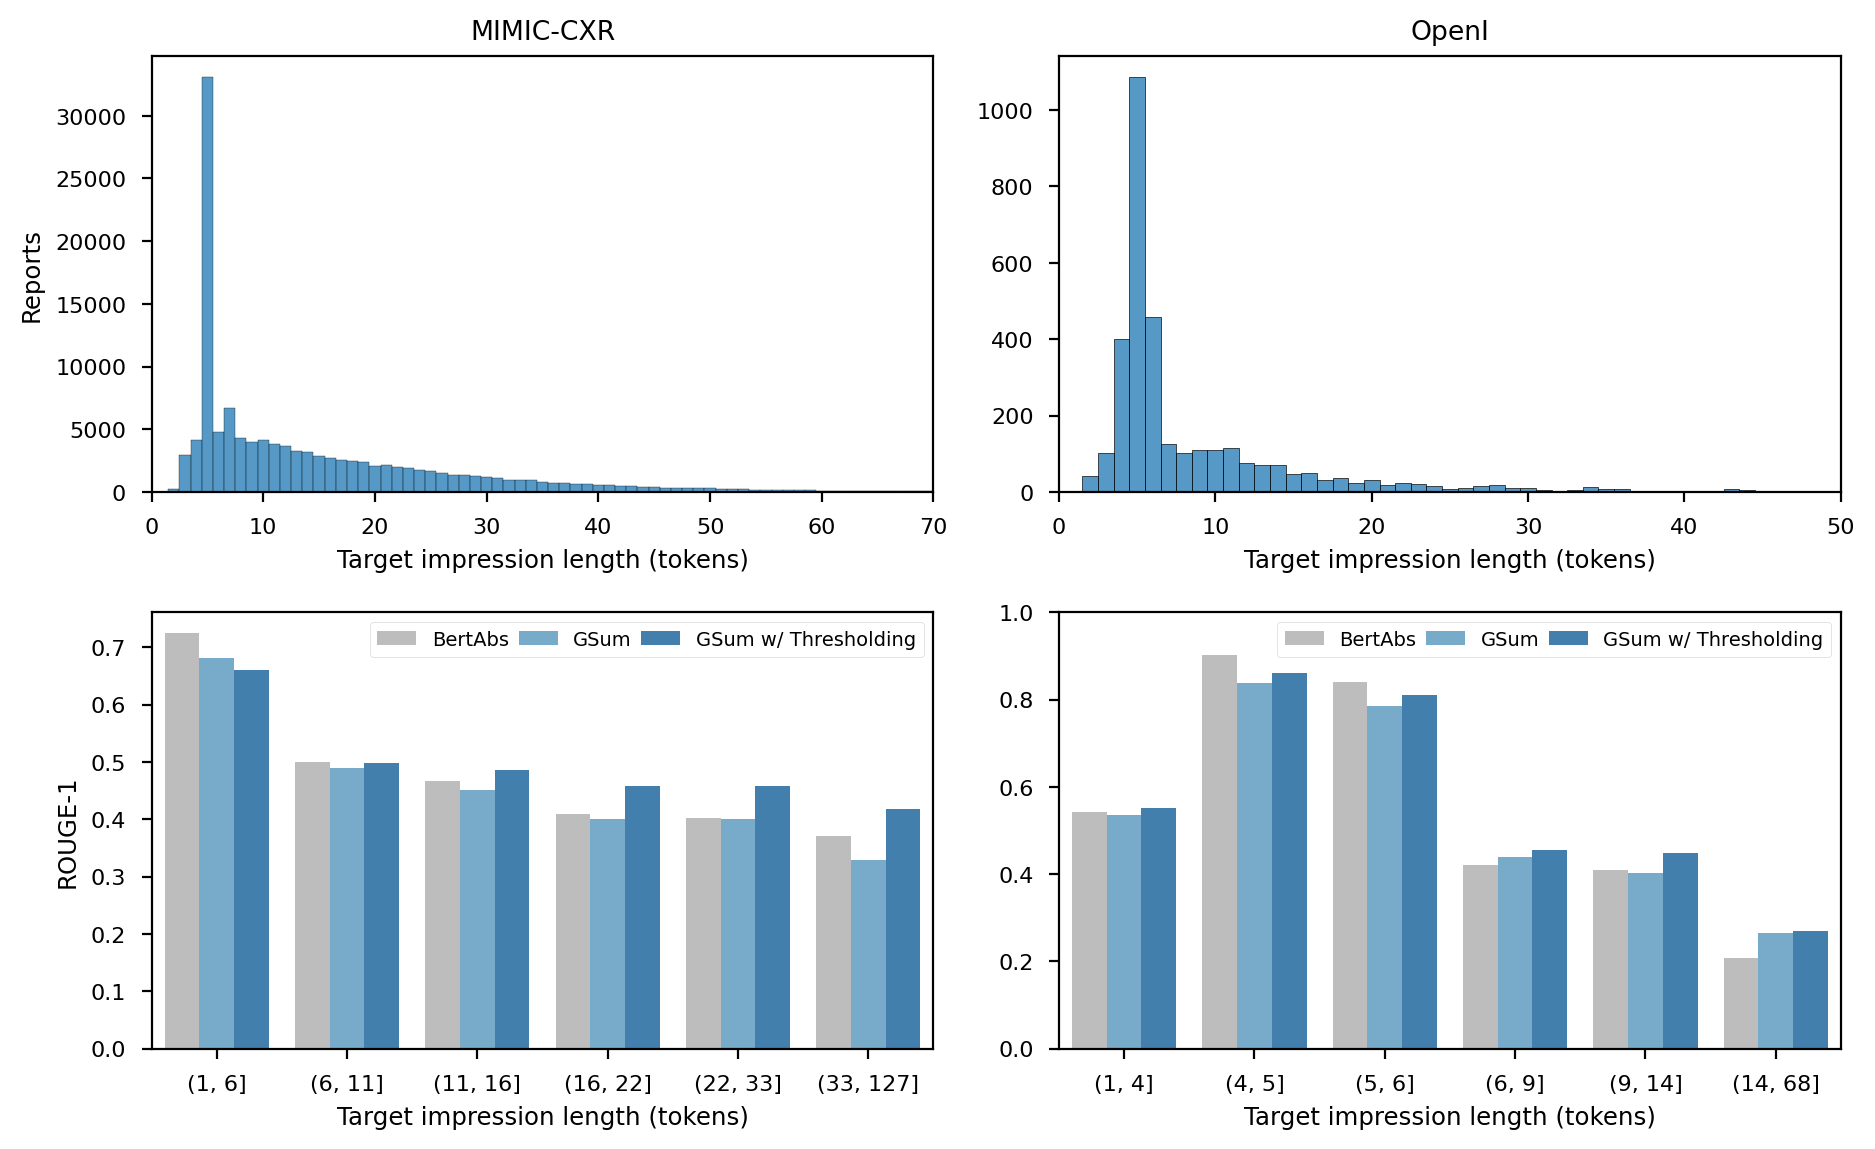

In [29]:
# textwidth as measured in pdf
width = 6.32 * 1.5
height = width / 1.618 # golden ratio
figsize = (width, height)
# figsize = (6.8,5)

fig, axs = plt.subplots(2, 2, figsize=figsize)
axs = axs.flatten()


# MIMIC -- Length distribution
ax = axs[0]
sns.histplot(df_mimic, x="n_tokens_tgt", ax=ax, discrete=True)
ax.set_xlim(0, 70)
ax.set_xlabel('Target impression length (tokens)')
ax.set_ylabel('Reports');
ax.set_title('MIMIC-CXR')

# OpenI -- Length distribution
ax = axs[1]
sns.histplot(df_openi, x="n_tokens_tgt", ax=ax, discrete=True)
ax.set_xlim(0, 50)
ax.set_xlabel('Target impression length (tokens)')
ax.set_ylabel('');
ax.set_title('OpenI')


# MIMIC -- ROUGE by target length
ax = axs[2]
data = mimic_rouge_by_length.melt(var_name='Model', value_name='ROUGE-1', ignore_index=False).reset_index()
ax = sns.barplot(
    data=data,
    x='n_tokens_tgt',
    y='ROUGE-1',
    hue='Model',
    palette=c,
    ax=ax
);

edges = [1] + list(mimic_bins[1:])
x_tick_labels = []
for i, j in zip(edges, edges[1:]):
    i = int(i)
    j = int(j)
    x_tick_labels.append(f'({i}, {j}]')

ax.set_xticklabels(x_tick_labels)
plt.ylim([0, 0.8])
ax.set_xlabel('Target impression length (tokens)')
ax.set_ylabel('ROUGE-1')
ax.legend(loc="upper right", fontsize=7, ncol=3, columnspacing=0.5)


# OpenI -- ROUGE by target length
ax = axs[3]
data = openi_rouge_by_length.melt(var_name='Model', value_name='ROUGE-1', ignore_index=False).reset_index()
ax = sns.barplot(
    data=data,
    x='n_tokens_tgt',
    y='ROUGE-1',
    hue='Model',
    palette=c,
    ax=ax
);

edges = [1] + list(openi_bins[1:])
x_tick_labels = []
for i, j in zip(edges, edges[1:]):
    i = int(i)
    j = int(j)
    x_tick_labels.append(f'({i}, {j}]')

ax.set_xticklabels(x_tick_labels)
# plt.ylim([0.3, 0.8])
ax.set_ylim([0, 1])
ax.set_xlabel('Target impression length (tokens)')
ax.set_ylabel('')
ax.legend(loc="upper right", fontsize=7, ncol=3, columnspacing=0.5)

plt.tight_layout()

with PdfPages('figures/mimic-openi-tgt-len-rouge1.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0.02)

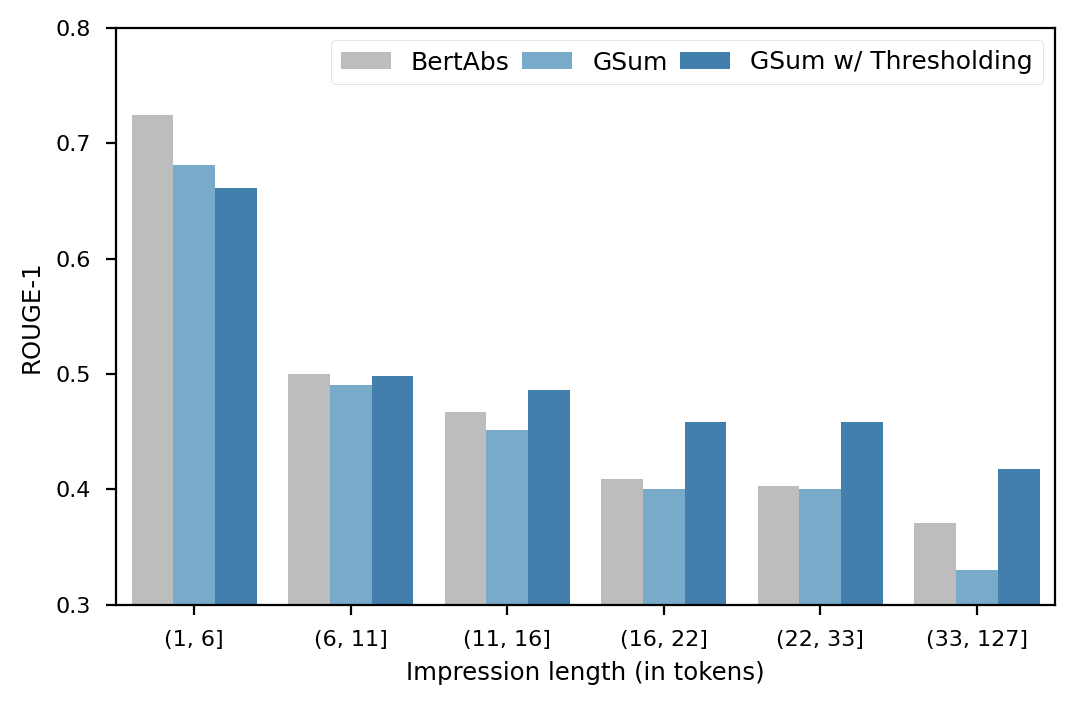

In [30]:
# textwidth as measured in pdf
width = 3.03 * 2
height = width / 1.618 # golden ratio
figsize = (width, height)
# figsize = (6.8,5)

fig = plt.figure(figsize=figsize)
data = mimic_rouge_by_length.melt(var_name='Model', value_name='ROUGE-1', ignore_index=False).reset_index()
ax = sns.barplot(
    data=data,
    x='n_tokens_tgt',
    y='ROUGE-1',
    hue='Model',
    palette=c,
);

edges = [1] + list(mimic_bins[1:])
x_tick_labels = []
for i, j in zip(edges, edges[1:]):
    i = int(i)
    j = int(j)
    x_tick_labels.append(f'({i}, {j}]')

ax.set_xticklabels(x_tick_labels)
plt.ylim([0.3, 0.8])
plt.xlabel('Impression length (in tokens)')
plt.ylabel('ROUGE-1')
plt.legend(loc="upper right", fontsize=9, ncol=3, columnspacing=0.5)

# sns.despine()

with PdfPages('figures/mimic-official-r1-by-tgt-len.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0.02)